# Advanced Construction Materials

2021-36822 황희영

Project 3) Machine Learning to identify the sonication process of CNT for better dispersion of CNT in concrete

# *Step 1. Setting code*

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "cnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [6]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import os
import random

# *Step 2. processing image*

In [7]:
# Download Image Samples from Github
!git clone https://github.com/heeyoung1217/CNT_CNN

Cloning into 'CNT_CNN'...
remote: Enumerating objects: 197, done.
remote: Total 197 (delta 0), reused 0 (delta 0), pack-reused 197
Receiving objects: 100% (197/197), 147.40 MiB | 24.12 MiB/s, done.
Resolving deltas: 100% (1/1), done.


In [8]:
DIR = '/content/CNT_CNN'
CATEGORIES = ['0.1-No', '0.1-Sonic', '0.05-No', '0.05-Sonic','0.2-No', '0.2-Sonic','0.4-No', '0.4-Sonic'] 

In [9]:
CNT_IMG = []

for category in CATEGORIES:
    Path = os.path.join(DIR, category)

    for file in os.listdir(Path):
        # Change Image to Numpy array in grayscale
        img_array = cv2.imread(os.path.join(Path, file), cv2.IMREAD_GRAYSCALE)
        # Save image array, category as 0 or 1, and file name to CNT_IMG
        CNT_IMG.append([img_array, CATEGORIES.index(category), file])

In [10]:
# Four splits in row and six splits in column -> 24 small samples from one 1080 x 1920 image
n_row = 4
n_col = 6

# Resize image to 224 x 224 pixels
img_size = 224

SMALL_IMG = []

for img_array, label, name in CNT_IMG:
    for i in range(n_row):
        for k in range(n_col):
            height = int(img_array.shape[0]/n_row)
            width = int(img_array.shape[1]/n_col)

            small_img = img_array[i*height:(i+1)*height, k*width:(k+1)*width] # Split -> 270 x 320

            small_img = cv2.resize(small_img, (img_size, img_size)) # Resize -> 224 x 224

            # Normalization
            small_img = small_img / 223.0 

            SMALL_IMG.append([small_img, label, name])

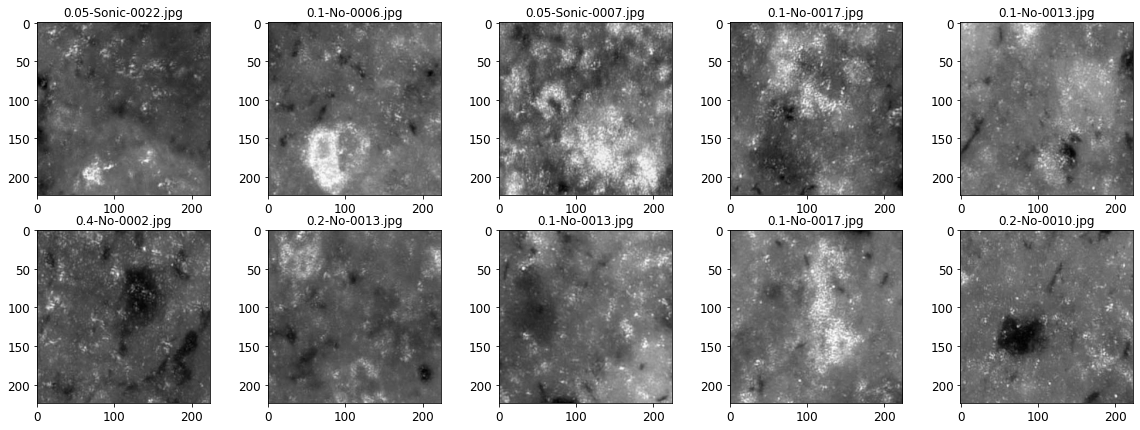

In [11]:
# Show 10 Random Images out of 192(= 8 x 24) Small Image Samples

RANDOM_IMG = random.sample(SMALL_IMG, 10)

i=1

for img_array, label, name in RANDOM_IMG:
    

    plt.rcParams["figure.figsize"] = (20,7)

    plt.subplot(2,5,i)
    plt.imshow(img_array, cmap='gray')
    plt.title(name)
    plt.show

    i+=1

In [12]:
# Shuffle images to be trained well

random.shuffle(SMALL_IMG)

In [13]:
# 3000 Samples -> Train set
# 360 Samples -> Test set

Train_Data = SMALL_IMG[:3000]
Test_Data = SMALL_IMG[3000:]

In [14]:
x_train = []
y_train = []

for img_array, label, name in Train_Data:
    x_train.append(img_array)
    y_train.append(label)

# Change List to Numpy
x_train = np.array(x_train).reshape(3000, img_size, img_size, 1) # (instances, height, width, depth)
y_train = np.array(y_train)

print(x_train.shape, y_train.shape)

(3000, 224, 224, 1) (3000,)


# *step 3. 기존의 CNN 코드>> 결과 및 피드백*

In [16]:
tf.model = tf.keras.Sequential()

# Conv -> ReLU -> Conv -> ReLU -> Maxpooling
tf.model.add(tf.keras.layers.Conv2D(filters=64, input_shape=(img_size,img_size,1), kernel_size=(3,3), # filters = num of filters / kernel_size = (filter height, filter width)
                                    kernel_initializer='glorot_normal',activation='relu', padding='same')) # padding = 'same' -> size of input = size of output
tf.model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), 
                                    kernel_initializer='glorot_normal',activation='relu', padding='same')) 
tf.model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2))) # pool_size = (filter_size, stride)

# Conv -> ReLU -> Conv -> ReLU -> Maxpooling
tf.model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), kernel_initializer='glorot_normal', 
                                    activation='relu', padding='same'))
tf.model.add(tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), kernel_initializer='glorot_normal', 
                                    activation='relu', padding='same'))
tf.model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))

# Fully Connected
tf.model.add(tf.keras.layers.Flatten()) # 3D data -> 1D data
tf.model.add(tf.keras.layers.Dense(units=1, kernel_initializer='glorot_normal', activation='sigmoid'))

tf.model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=0.001), metrics=['accuracy'])
tf.model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_77 (Conv2D)           (None, 224, 224, 64)      640       
_________________________________________________________________
conv2d_78 (Conv2D)           (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_79 (Conv2D)           (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2d_80 (Conv2D)           (None, 112, 112, 256)     295168    
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 56, 56, 256)       0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 802816)           

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [17]:
# Train
tf.model.fit(x_train, y_train, validation_split=0.1, batch_size=32, epochs=10)

Epoch 1/10
85/85 [==============================] - 83s 540ms/step - loss: -2998399488.0000 - accuracy: 0.1922 - val_loss: -26485563392.0000 - val_accuracy: 0.2000
Epoch 2/10
85/85 [==============================] - 42s 499ms/step - loss: -843223400448.0000 - accuracy: 0.1926 - val_loss: -3542717300736.0000 - val_accuracy: 0.2000
Epoch 3/10
85/85 [==============================] - 42s 498ms/step - loss: -18932100497408.0000 - accuracy: 0.1926 - val_loss: -50284139118592.0000 - val_accuracy: 0.2000
Epoch 4/10
85/85 [==============================] - 42s 498ms/step - loss: -143767973658624.0000 - accuracy: 0.1926 - val_loss: -293491255017472.0000 - val_accuracy: 0.2000
Epoch 5/10
85/85 [==============================] - 42s 498ms/step - loss: -617632000638976.0000 - accuracy: 0.1926 - val_loss: -1082237269311488.0000 - val_accuracy: 0.2000
Epoch 6/10
85/85 [==============================] - 42s 499ms/step - loss: -1899222727131136.0000 - accuracy: 0.1926 - val_loss: -2978827181490176.000

- accuracy 가 20%로 매우 낮음, 배치 사이즈를 32>100으로 키워서 모델 다시 훈련

In [18]:
# Train
tf.model.fit(x_train, y_train, validation_split=0.1, batch_size=100, epochs=10)

Epoch 1/10
27/27 [==============================] - 70s 2s/step - loss: -48665428322418688.0000 - accuracy: 0.1926 - val_loss: -52200482759770112.0000 - val_accuracy: 0.2000
Epoch 2/10
27/27 [==============================] - 53s 2s/step - loss: -56749505961263104.0000 - accuracy: 0.1926 - val_loss: -60893006940602368.0000 - val_accuracy: 0.2000
Epoch 3/10
27/27 [==============================] - 55s 2s/step - loss: -65961107004588032.0000 - accuracy: 0.1926 - val_loss: -70514347863965696.0000 - val_accuracy: 0.2000
Epoch 4/10
27/27 [==============================] - 53s 2s/step - loss: -76272236855558144.0000 - accuracy: 0.1926 - val_loss: -81242553399115776.0000 - val_accuracy: 0.2000
Epoch 5/10
27/27 [==============================] - 53s 2s/step - loss: -87689642907795456.0000 - accuracy: 0.1926 - val_loss: -93416328961982464.0000 - val_accuracy: 0.2000
Epoch 6/10
27/27 [==============================] - 54s 2s/step - loss: -100548285365747712.0000 - accuracy: 0.1926 - val_loss: -1

KeyboardInterrupt: ignored

배치사이즈 100으로 설정하였으나, accuracy 향상에 영향X
- 기존의 CNN 모델은 해당 프로젝트에 적합하지 않은 것으로 판단
   기존의 CNN 모델을 변형하여 수정된 CNN 적용

# *Setp 4. 변형된 CNN 코드*

# **4-1. 합성층 개수의 증가**
- 오히려 accuracy 가 감소하고, epoch 당 시간이 증가 >> 비효율적이라고 판단

In [36]:
tf.model = tf.keras.Sequential()

# Conv -> ReLU -> Conv -> ReLU -> Maxpooling
tf.model.add(tf.keras.layers.Conv2D(filters=64, input_shape=(img_size,img_size,1), kernel_size=(7,7), # filters = num of filters / kernel_size = (filter height, filter width)
                                    kernel_initializer='glorot_normal',activation='relu', padding='same')) # padding = 'same' -> size of input = size of output
tf.model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(7,7), 
                                    kernel_initializer='glorot_normal',activation='relu', padding='same')) 
tf.model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(7,7), 
                                    kernel_initializer='glorot_normal',activation='relu', padding='same'))
tf.model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2))) # pool_size = (filter_size, stride)

# Conv -> ReLU -> Conv -> ReLU -> Maxpooling
tf.model.add(tf.keras.layers.Conv2D(filters=128, input_shape=(img_size,img_size,1), kernel_size=(7,7), # filters = num of filters / kernel_size = (filter height, filter width)
                                    kernel_initializer='glorot_normal',activation='relu', padding='same'))
tf.model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(7,7), 
                                    kernel_initializer='glorot_normal',activation='relu', padding='same')) 
tf.model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(7,7), 
                                    kernel_initializer='glorot_normal',activation='relu', padding='same')) 
tf.model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(7,7), 
                                    kernel_initializer='glorot_normal',activation='relu', padding='same')) 
tf.model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2))) # pool_size = (filter_size, stride)


tf.model.add(tf.keras.layers.Conv2D(filters=256, input_shape=(img_size,img_size,1), kernel_size=(7,7), # filters = num of filters / kernel_size = (filter height, filter width)
                                    kernel_initializer='glorot_normal',activation='relu', padding='same'))
tf.model.add(tf.keras.layers.Conv2D(filters=256, kernel_size=(7,7), 
                                    kernel_initializer='glorot_normal',activation='relu', padding='same')) 
tf.model.add(tf.keras.layers.Conv2D(filters=256, kernel_size=(7,7), 
                                    kernel_initializer='glorot_normal',activation='relu', padding='same')) 
tf.model.add(tf.keras.layers.Conv2D(filters=256, kernel_size=(7,7), 
                                    kernel_initializer='glorot_normal',activation='relu', padding='same')) 
tf.model.add(tf.keras.layers.Conv2D(filters=256, kernel_size=(7,7), 
                                    kernel_initializer='glorot_normal',activation='relu', padding='same')) 
tf.model.add(tf.keras.layers.Conv2D(filters=256, kernel_size=(7,7), 
                                    kernel_initializer='glorot_normal',activation='relu', padding='same')) 
tf.model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))

tf.model.add(tf.keras.layers.Conv2D(filters=512, input_shape=(img_size,img_size,1), kernel_size=(7,7), # filters = num of filters / kernel_size = (filter height, filter width)
                                    kernel_initializer='glorot_normal',activation='relu', padding='same'))
tf.model.add(tf.keras.layers.Conv2D(filters=512, kernel_size=(7,7), 
                                    kernel_initializer='glorot_normal',activation='relu', padding='same')) 
tf.model.add(tf.keras.layers.Conv2D(filters=512, kernel_size=(7,7), 
                                    kernel_initializer='glorot_normal',activation='relu', padding='same')) 
tf.model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))

# Fully Connected
tf.model.add(tf.keras.layers.Flatten()) # 3D data -> 1D data
tf.model.add(tf.keras.layers.Dense(units=1, kernel_initializer='glorot_normal', activation='softmax'))

tf.model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=0.001), metrics=['accuracy'])
tf.model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_269 (Conv2D)          (None, 224, 224, 64)      3200      
_________________________________________________________________
conv2d_270 (Conv2D)          (None, 224, 224, 64)      200768    
_________________________________________________________________
conv2d_271 (Conv2D)          (None, 224, 224, 64)      200768    
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_272 (Conv2D)          (None, 112, 112, 128)     401536    
_________________________________________________________________
conv2d_273 (Conv2D)          (None, 112, 112, 128)     802944    
_________________________________________________________________
conv2d_274 (Conv2D)          (None, 112, 112, 128)   

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [37]:
# Train
tf.model.fit(x_train, y_train, validation_split=0.1, batch_size=32, epochs=10)

Epoch 1/10
85/85 [==============================] - 417s 4s/step - loss: nan - accuracy: 0.1885 - val_loss: nan - val_accuracy: 0.1900
Epoch 2/10
44/85 [==============>...............] - ETA: 2:46 - loss: nan - accuracy: 0.1797

KeyboardInterrupt: ignored

# **4-2. ResNet-34 CNN 적용**
- 훈련 속도는 빨라졌으나, 여전히 낮은 accuracy
- 기존의 CNN 으로는 정확한 분류가 어렵다고 판단
- 단순히 NO, SONIC 으로만 구분하여 추가적인 훈련 진행

In [24]:
DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, strides=1,
                        padding="SAME", use_bias=False)

class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers = [
            DefaultConv2D(filters, strides=strides),
            keras.layers.BatchNormalization(),
            self.activation,
            DefaultConv2D(filters),
            keras.layers.BatchNormalization()]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                DefaultConv2D(filters, kernel_size=1, strides=strides),
                keras.layers.BatchNormalization()]

    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

NameError: ignored

In [46]:
tf.model = tf.keras.Sequential()

# Conv -> ReLU -> Conv -> ReLU -> Maxpooling
tf.model.add(tf.keras.layers.Conv2D(filters=64, input_shape=(img_size,img_size,1), kernel_size=(7,7), # filters = num of filters / kernel_size = (filter height, filter width)
                                    kernel_initializer='glorot_normal',activation='relu', padding='same')) # padding = 'same' -> size of input = size of output

tf.model.add(tf.keras.layers.BatchNormalization())
tf.model.add(tf.keras.layers.Activation("relu"))
tf.model.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding="SAME"))

prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    strides = 1 if filters == prev_filters else 2
    tf.model.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters
# Fully Connected
tf.model.add(tf.keras.layers.GlobalAvgPool2D())
tf.model.add(tf.keras.layers.Flatten()) # 3D data -> 1D data
tf.model.add(tf.keras.layers.Dense(units=1, kernel_initializer='glorot_normal', activation='softmax'))

tf.model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=0.001), metrics=['accuracy'])
tf.model.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_322 (Conv2D)          (None, 224, 224, 64)      3200      
_________________________________________________________________
batch_normalization_187 (Bat (None, 224, 224, 64)      256       
_________________________________________________________________
activation_10 (Activation)   (None, 224, 224, 64)      0         
_________________________________________________________________
max_pooling2d_46 (MaxPooling (None, 112, 112, 64)      0         
_________________________________________________________________
residual_unit_81 (ResidualUn (None, 112, 112, 64)      74240     
_________________________________________________________________
residual_unit_82 (ResidualUn (None, 112, 112, 64)      74240     
_________________________________________________________________
residual_unit_83 (ResidualUn (None, 112, 112, 64)    

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [47]:
# Train
tf.model.fit(x_train, y_train, validation_split=0.1, batch_size=32, epochs=10)

Epoch 1/10
85/85 [==============================] - 103s 1s/step - loss: -174.1692 - accuracy: 0.1926 - val_loss: -294.0740 - val_accuracy: 0.2000
Epoch 2/10
85/85 [==============================] - 96s 1s/step - loss: -559.7300 - accuracy: 0.1926 - val_loss: -2504.1394 - val_accuracy: 0.2000
Epoch 3/10
85/85 [==============================] - 96s 1s/step - loss: -1170.9332 - accuracy: 0.1926 - val_loss: -97.7237 - val_accuracy: 0.2000
Epoch 4/10
85/85 [==============================] - 96s 1s/step - loss: -2006.5046 - accuracy: 0.1926 - val_loss: -240.7607 - val_accuracy: 0.2000
Epoch 5/10
85/85 [==============================] - 96s 1s/step - loss: -3025.0149 - accuracy: 0.1926 - val_loss: -984.4594 - val_accuracy: 0.2000
Epoch 6/10
85/85 [==============================] - 96s 1s/step - loss: -4254.6851 - accuracy: 0.1926 - val_loss: -62193.9805 - val_accuracy: 0.2000
Epoch 7/10
85/85 [==============================] - 96s 1s/step - loss: -5754.3350 - accuracy: 0.1926 - val_loss: -74

# Step 5. 최종 모델 설정 및 분석 결과

# 5-1. 기존 CNN 

In [30]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import os
import random

In [31]:
# initial setting for importing files from google drive
!pip install -U -q PyDrive
!pip install jscatter
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [32]:
DIR = '/content/drive/My Drive/CNN'
CATEGORIES = ['No', 'Sonic'] 

In [33]:
CNT_IMG = []

for category in CATEGORIES:
    Path = os.path.join(DIR, category)

    for file in os.listdir(Path):
        # Change Image to Numpy array in grayscale
        img_array = cv2.imread(os.path.join(Path, file), cv2.IMREAD_GRAYSCALE)
        # Save image array, category as 0 or 1, and file name to CNT_IMG
        CNT_IMG.append([img_array, CATEGORIES.index(category), file])

In [34]:
# Four splits in row and six splits in column -> 6 small samples from one 1080 x 1920 image
# Ram 용량으로 인해 small smaple 조정
n_row = 2
n_col = 3

# Resize image to 224 x 224 pixels
img_size = 224

SMALL_IMG = []

for img_array, label, name in CNT_IMG:
    for i in range(n_row):
        for k in range(n_col):
            height = int(img_array.shape[0]/n_row)
            width = int(img_array.shape[1]/n_col)

            small_img = img_array[i*height:(i+1)*height, k*width:(k+1)*width] # Split -> 270 x 320

            small_img = cv2.resize(small_img, (img_size, img_size)) # Resize -> 256 x 256

            # Normalization
            small_img = small_img / 223.0 

            SMALL_IMG.append([small_img, label, name])

In [35]:
# 1700 Samples -> Train set
# 232Samples -> Test set

Train_Data = SMALL_IMG[:1700]
Test_Data = SMALL_IMG[1700:]

In [36]:
len(Train_Data)

1700

In [37]:
x_train = []
y_train = []

for img_array, label, name in Train_Data:
    x_train.append(img_array)
    y_train.append(label)

# Change List to Numpy
x_train = np.array(x_train).reshape(1700, img_size, img_size, 1) # (instances, height, width, depth)
y_train = np.array(y_train)

print(x_train.shape, y_train.shape)

(1700, 224, 224, 1) (1700,)


In [38]:
# Build TensorFlow model -> CNN for Logistic Regression -> 2 Class Classification
tf.model = tf.keras.Sequential()

# Conv -> ReLU -> Conv -> ReLU -> Maxpooling
tf.model.add(tf.keras.layers.Conv2D(filters=64, input_shape=(img_size,img_size,1), kernel_size=(3,3), # filters = num of filters / kernel_size = (filter height, filter width)
                                    kernel_initializer='glorot_normal',activation='relu', padding='same')) # padding = 'same' -> size of input = size of output
tf.model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), 
                                    kernel_initializer='glorot_normal',activation='relu', padding='same')) 
tf.model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2))) # pool_size = (filter_size, stride)

# Conv -> ReLU -> Conv -> ReLU -> Maxpooling
tf.model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), kernel_initializer='glorot_normal', 
                                    activation='relu', padding='same'))
tf.model.add(tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), kernel_initializer='glorot_normal', 
                                    activation='relu', padding='same'))
tf.model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))

# Fully Connected
tf.model.add(tf.keras.layers.Flatten()) # 3D data -> 1D data
tf.model.add(tf.keras.layers.Dense(units=1, kernel_initializer='glorot_normal', activation='sigmoid'))

tf.model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=0.001), metrics=['accuracy'])
tf.model.summary()

# Train
tf.model.fit(x_train, y_train, validation_split=0.1, batch_size=100, epochs=40)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_49 (Conv2D)           (None, 224, 224, 64)      640       
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2d_52 (Conv2D)           (None, 112, 112, 256)     295168    
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 56, 56, 256)       0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 802816)           

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/40
16/16 [==============================] - 30s 2s/step - loss: 0.8647 - accuracy: 0.5830 - val_loss: 0.8515 - val_accuracy: 0.0000e+00
Epoch 2/40
16/16 [==============================] - 29s 2s/step - loss: 0.5936 - accuracy: 0.6601 - val_loss: 0.4708 - val_accuracy: 0.9765
Epoch 3/40
16/16 [==============================] - 29s 2s/step - loss: 0.5550 - accuracy: 0.6771 - val_loss: 0.3018 - val_accuracy: 1.0000
Epoch 4/40
16/16 [==============================] - 29s 2s/step - loss: 0.5729 - accuracy: 0.6869 - val_loss: 0.3888 - val_accuracy: 1.0000
Epoch 5/40
16/16 [==============================] - 29s 2s/step - loss: 0.5544 - accuracy: 0.6902 - val_loss: 0.4496 - val_accuracy: 0.9647
Epoch 6/40
16/16 [==============================] - 29s 2s/step - loss: 0.5215 - accuracy: 0.6693 - val_loss: 0.3717 - val_accuracy: 1.0000
Epoch 7/40
16/16 [==============================] - 29s 2s/step - loss: 0.5278 - accuracy: 0.6889 - val_loss: 0.4214 - val_accuracy: 0.9647
Epoch 8/40
16/16

In [39]:
# Test set
x_test = []
y_test = []

for img_array, label, name in Test_Data:
    x_test.append(img_array)
    y_test.append(label)

x_test = np.array(x_test).reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

In [40]:
# Accuracy
Train_Accuracy = tf.model.evaluate(x_train, y_train)
Test_Accuracy = tf.model.evaluate(x_test, y_test)

8/8 [==============================] - 1s 133ms/step - loss: 1.6654 - accuracy: 0.5905


In [41]:
# Predict Test Set
Prediction = []

for pred in tf.model.predict(x_test):
    if pred > 0.5:
        Prediction.append('Sonic')
    else:
        Prediction.append('No')

[['Sonic' 'Sonic' 'No' 'Sonic' 'Sonic']
 ['Sonic' 'Sonic' 'Sonic' 'Sonic' 'Sonic']]


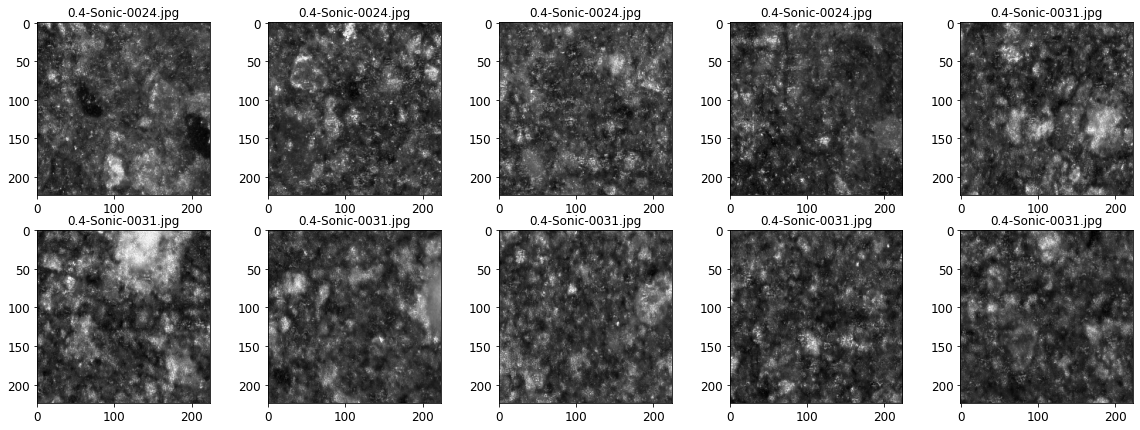

In [42]:
# Show First 10 Test Image Samples and Predictions

i = 1

for img_array, label, name in Test_Data[:10]:
    
    plt.rcParams["figure.figsize"] = (20,7)

    plt.subplot(2,5,i)
    plt.imshow(img_array, cmap='gray')
    plt.title(name)
    plt.show

    i+=1

print(np.array(Prediction[:10]).reshape(2,5))

# ResNet-34 CNN 

In [21]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "cnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [25]:
from functools import partial

DefaultConv2D = partial(keras.layers.Conv2D,
                        kernel_size=3, activation='relu', padding="SAME")

model = keras.models.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[28, 28, 1]),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=10, activation='softmax'),
])

In [26]:
DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, strides=1,
                        padding="SAME", use_bias=False)

class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers = [
            DefaultConv2D(filters, strides=strides),
            keras.layers.BatchNormalization(),
            self.activation,
            DefaultConv2D(filters),
            keras.layers.BatchNormalization()]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                DefaultConv2D(filters, kernel_size=1, strides=strides),
                keras.layers.BatchNormalization()]

    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

In [27]:
tf.model = tf.keras.Sequential()

# Conv -> ReLU -> Conv -> ReLU -> Maxpooling
tf.model.add(tf.keras.layers.Conv2D(filters=64, input_shape=(img_size,img_size,1), kernel_size=(7,7), # filters = num of filters / kernel_size = (filter height, filter width)
                                    kernel_initializer='glorot_normal',activation='relu', padding='same')) # padding = 'same' -> size of input = size of output

tf.model.add(tf.keras.layers.BatchNormalization())
tf.model.add(tf.keras.layers.Activation("relu"))
tf.model.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding="SAME"))

prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    strides = 1 if filters == prev_filters else 2
    tf.model.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters
# Fully Connected
tf.model.add(tf.keras.layers.GlobalAvgPool2D())
tf.model.add(tf.keras.layers.Flatten()) # 3D data -> 1D data
tf.model.add(tf.keras.layers.Dense(units=1, kernel_initializer='glorot_normal', activation='softmax'))

tf.model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=0.001), metrics=['accuracy'])
tf.model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 224, 224, 64)      3200      
_________________________________________________________________
batch_normalization (BatchNo (None, 224, 224, 64)      256       
_________________________________________________________________
activation (Activation)      (None, 224, 224, 64)      0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
residual_unit (ResidualUnit) (None, 112, 112, 64)      74240     
_________________________________________________________________
residual_unit_1 (ResidualUni (None, 112, 112, 64)      74240     
_________________________________________________________________
residual_unit_2 (ResidualUni (None, 112, 112, 64)     

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [29]:
# Train
tf.model.fit(x_train, y_train, validation_split=0.1, batch_size=50, epochs=40)

Epoch 1/40
31/31 [==============================] - 123s 4s/step - loss: 0.7518 - accuracy: 0.3647 - val_loss: 63617.0117 - val_accuracy: 1.0000
Epoch 2/40
31/31 [==============================] - 56s 2s/step - loss: 0.4809 - accuracy: 0.3647 - val_loss: 307.8429 - val_accuracy: 1.0000
Epoch 3/40
31/31 [==============================] - 56s 2s/step - loss: 0.4856 - accuracy: 0.3647 - val_loss: 2.1360 - val_accuracy: 1.0000
Epoch 4/40
31/31 [==============================] - 56s 2s/step - loss: 0.4585 - accuracy: 0.3647 - val_loss: 0.3787 - val_accuracy: 1.0000
Epoch 5/40
31/31 [==============================] - 56s 2s/step - loss: 0.4294 - accuracy: 0.3647 - val_loss: 0.2081 - val_accuracy: 1.0000
Epoch 6/40
31/31 [==============================] - 56s 2s/step - loss: 0.4584 - accuracy: 0.3647 - val_loss: 0.0825 - val_accuracy: 1.0000
Epoch 7/40
31/31 [==============================] - 56s 2s/step - loss: 0.4152 - accuracy: 0.3647 - val_loss: 0.1385 - val_accuracy: 1.0000
Epoch 8/40
31

In [43]:
# Test set
x_test = []
y_test = []

for img_array, label, name in Test_Data:
    x_test.append(img_array)
    y_test.append(label)

x_test = np.array(x_test).reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

In [44]:
# Accuracy
Train_Accuracy = tf.model.evaluate(x_train, y_train)
Test_Accuracy = tf.model.evaluate(x_test, y_test)

8/8 [==============================] - 1s 133ms/step - loss: 1.6654 - accuracy: 0.5905


In [45]:
# Predict Test Set
Prediction = []

for pred in tf.model.predict(x_test):
    if pred > 0.5:
        Prediction.append('Sonic')
    else:
        Prediction.append('No')

[['Sonic' 'Sonic' 'No' 'Sonic' 'Sonic']
 ['Sonic' 'Sonic' 'Sonic' 'Sonic' 'Sonic']]


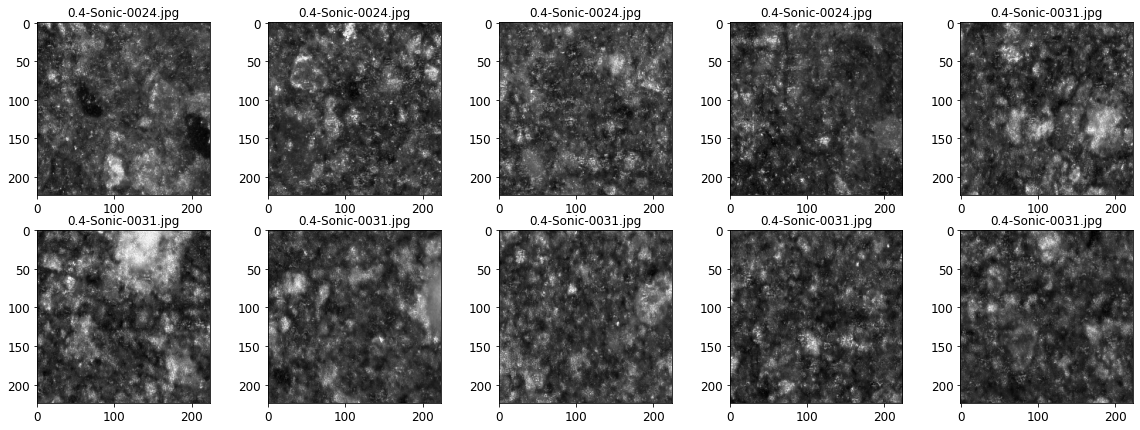

In [46]:
# Show First 10 Test Image Samples and Predictions

i = 1

for img_array, label, name in Test_Data[:10]:
    
    plt.rcParams["figure.figsize"] = (20,7)

    plt.subplot(2,5,i)
    plt.imshow(img_array, cmap='gray')
    plt.title(name)
    plt.show

    i+=1

print(np.array(Prediction[:10]).reshape(2,5))